In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# For the LR scheduler and early stopping logic
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/SLACResearch_Ivan/preprocessed_SNL_data.h5'  # Update with your file path

In [4]:
with h5py.File(file_path, 'r') as hf:
    print(hf)
    X_train = hf['X_train'][:]
    X_test  = hf['X_test'][:]
    Ato4l_data  = hf['Ato4l_data'][:]
    hToTauTau_data  = hf['hToTauTau_data'][:]
    hChToTauNu_data  = hf['hChToTauNu_data'][:]
    leptoquark_data = hf['leptoquark_data'][:]
    print("Data loaded from preprocessed_SNL_data.h5")

<HDF5 file "preprocessed_SNL_data.h5" (mode r)>
Data loaded from preprocessed_SNL_data.h5


In [5]:
def analyze_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")

    for col in range(57):
        column = arr[:, col]

        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()

        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
#analyze_columns(X_train)
print(X_train.shape)

(3200000, 57)


In [6]:
def analyze_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")

    for col in range(57):
        column = arr[:, col]

        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()

        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
analyze_columns(X_train)

Column 1:
  Mean: -0.0000
  Min: -1.9571
  Max: 53.1526
  Contains NaN: False

Column 2:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 3:
  Mean: 0.0000
  Min: -1.7323
  Max: 1.7311
  Contains NaN: False

Column 4:
  Mean: -0.0000
  Min: -0.9537
  Max: 47.1318
  Contains NaN: False

Column 5:
  Mean: -0.0000
  Min: -2.4819
  Max: 2.4821
  Contains NaN: False

Column 6:
  Mean: -0.0000
  Min: -2.3496
  Max: 2.3489
  Contains NaN: False

Column 7:
  Mean: -0.0000
  Min: -0.0355
  Max: 200.8080
  Contains NaN: False

Column 8:
  Mean: -0.0000
  Min: -43.0203
  Max: 43.0213
  Contains NaN: False

Column 9:
  Mean: 0.0000
  Min: -34.6662
  Max: 34.6653
  Contains NaN: False

Column 10:
  Mean: 0.0000
  Min: -0.0108
  Max: 302.0646
  Contains NaN: False

Column 11:
  Mean: -0.0000
  Min: -181.6179
  Max: 181.7817
  Contains NaN: False

Column 12:
  Mean: -0.0000
  Min: -130.9459
  Max: 130.8367
  Contains NaN: False

Column 13:
  Mean: -0.0000
  Min: -0.0028
  Max:

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
class Encoder(nn.Module):
    """
    PyTorch equivalent of your encoder:
      - Input -> Dense(h_dim1, ReLU) -> Dense(h_dim2, ReLU) -> z_mean, z_log_var
    """
    def __init__(self, input_dim, h_dim1, h_dim2, latent_dim, weight_decay=1e-3):
        super().__init__()
        # NOTE: In PyTorch, L2 (weight decay) is typically handled by the optimizer's `weight_decay` parameter.
        #       L1 regularization needs custom application (not shown here).

        self.dense1 = nn.Linear(input_dim, h_dim1)
        self.dense2 = nn.Linear(h_dim1, h_dim2)
        self.z_mean = nn.Linear(h_dim2, latent_dim)
        self.z_log_var = nn.Linear(h_dim2, latent_dim)

        nn.init.kaiming_normal_(self.dense1.weight, nonlinearity='relu')
        nn.init.zeros_(self.dense1.bias)

        nn.init.kaiming_normal_(self.dense2.weight, nonlinearity='relu')
        nn.init.zeros_(self.dense2.bias)

        nn.init.kaiming_normal_(self.z_mean.weight, nonlinearity='linear')
        nn.init.zeros_(self.z_mean.bias)

        nn.init.zeros_(self.z_log_var.weight)
        nn.init.zeros_(self.z_log_var.bias)

    def forward(self, x):
        """
        Returns z_mean, z_log_var for the input x
        """
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var


class Decoder(nn.Module):
    """
    PyTorch equivalent of your decoder:
      - Input(latent) -> Dense(h_dim2, ReLU) -> Dense(h_dim1, ReLU) -> Dense(input_dim)
    """
    def __init__(self, input_dim, h_dim1, h_dim2, latent_dim, weight_decay=1e-3):
        super().__init__()

        self.dense1 = nn.Linear(latent_dim, h_dim2)
        self.dense2 = nn.Linear(h_dim2, h_dim1)
        self.out = nn.Linear(h_dim1, input_dim)

        nn.init.kaiming_normal_(self.dense1.weight, nonlinearity='relu')
        nn.init.zeros_(self.dense1.bias)

        nn.init.kaiming_normal_(self.dense2.weight, nonlinearity='relu')
        nn.init.zeros_(self.dense2.bias)

        nn.init.kaiming_normal_(self.out.weight, nonlinearity='linear')
        nn.init.zeros_(self.out.bias)

    def forward(self, z):
        x = F.relu(self.dense1(z))
        x = F.relu(self.dense2(x))
        x = self.out(x)
        return x


def reparameterize(z_mean, z_log_var):

    epsilon = torch.randn_like(z_mean)
    return z_mean + torch.exp(0.5 * z_log_var) * epsilon


In [9]:
def custom_mse_loss_with_multi_index_scaling(data, recon):

    # scale factors

    jet_scale = 1.0
    tau_scale = 1.0
    muon_scale = 1.0
    met_scale = 1.0
    em_scale = 1.0

    scale_dict = {
        0: met_scale,
        3: em_scale, 6: em_scale, 9: em_scale, 12: em_scale,
        15: tau_scale, 18: tau_scale, 21: tau_scale, 24: tau_scale,
        27: jet_scale, 30: jet_scale, 33: jet_scale, 36: jet_scale, 39: jet_scale, 42: jet_scale,
        45: muon_scale, 48: muon_scale, 51: muon_scale, 54: muon_scale
    }

    # Create scaling tensor
    scale_tensor = torch.ones_like(data)
    for index, factor in scale_dict.items():
        # Overwrite the scaling at 'index' for all batch elements
        scale_tensor[:, index] = factor

    scaled_data = data * scale_tensor
    scaled_recon = recon * scale_tensor

    # Hardcoded lists for eta and phi indices
    eta_indices = [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
    phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56]

    # 1) Force the first eta (index = 1) to zero in the reconstruction
    scaled_recon[:, 1] = 0.0

    # 2) Apply constraints to eta
    for i in eta_indices:
        scaled_recon[:, i] = 3.0 * torch.tanh(scaled_recon[:, i] / 3.0)

    # 3) Apply constraints to phi
    pi_val = 3.14159265258979
    for i in phi_indices:
        scaled_recon[:, i] = pi_val * torch.tanh(scaled_recon[:, i] / pi_val)

    # MSE across last dimension, then sum over batch
    mse_per_sample = F.mse_loss(scaled_data, scaled_recon, reduction='none')  # shape: [batch, features]
    mse_per_sample = mse_per_sample.mean(dim=1)  # average over features => shape: [batch]
    return mse_per_sample.sum()

In [28]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, steps_per_epoch=3125, cycle_length=10, min_beta=0.1, max_beta=0.8):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.steps_per_epoch = steps_per_epoch

        # Annealing parameters
        self.cycle_length = cycle_length
        self.min_beta = min_beta
        self.max_beta = max_beta

        # We update 'iteration' in training loop to track where we are
        self.register_buffer('iteration', torch.tensor(0.0))

    def cyclical_annealing_beta(self):
        # total steps in one cycle
        steps_per_cycle = self.steps_per_epoch * self.cycle_length

        cycle = torch.floor(1.0 + self.iteration / steps_per_cycle)
        x = torch.abs(self.iteration/steps_per_cycle - cycle + 1)
        beta = self.min_beta + (self.max_beta - self.min_beta) * torch.min(x, torch.tensor(1.0, device=x.device))
        return beta

    def forward(self, x):
        """
        Returns:
          - z_mean, z_log_var, z, reconstruction
        Used primarily for inference; the loss is computed in the training loop.
        """
        z_mean, z_log_var = self.encoder(x)
        z = reparameterize(z_mean, z_log_var)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, z, reconstruction

    def step(self, batch):
        """
        Single gradient-accumulation step (train or validation).
        Returns total_loss, reconstruction_loss, kl_loss, current_beta
        """
        x = batch[0].to(DEVICE)

        # 1) Encode, decode
        z_mean, z_log_var, z, recon = self.forward(x)

        # 2) Mask out zeros in x
        mask = (x != 0).float()
        masked_x = x * mask
        masked_recon = recon * mask

        # 3) Weighted reconstruction loss
        beta = self.cyclical_annealing_beta()
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(masked_x, masked_recon)
        reconstruction_loss = reconstruction_loss * (1.0 - beta)

        # 4) KL loss
        kl = -0.5 * (1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
        kl_loss = kl.mean() * beta

        # 5) Total VAE loss
        total_loss = reconstruction_loss + kl_loss

        return total_loss, reconstruction_loss, kl_loss, beta
    def get_encoder_outputs(self, x):
        """
        Returns (z_mean, z_log_var) from the encoder,
        analogous to `model.get_layer("encoder").predict(x)` in Keras.
        """
        self.eval()
        with torch.no_grad():
            z_mean, z_log_var = self.encoder(x)
        return z_mean, z_log_var

    def predict(self, x):
        """
        For direct comparison to Keras's `model.predict(x)`,
        but here it returns (z_mean, z_log_var, z, reconstruction).
        """
        self.eval()
        with torch.no_grad():
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
        return z_mean, z_log_var, z, reconstruction

In [12]:
NUM_EPOCHS = 10
BATCH_SIZE = 1024
STOP_PATIENCE = 15
LR_PATIENCE = 10

In [13]:
def train_vae(
    model,
    optimizer,
    train_loader,
    val_loader=None,
    num_epochs=50,
    stop_patience=5,
    lr_patience=3,
    save_path="checkpoint_small.pth"
):
    """
    Example PyTorch training loop that mimics:
      - cyclical annealing
      - early stopping
      - reduce-on-plateau
    """
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=lr_patience, verbose=True)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss_accum = 0.0
        train_reco_accum = 0.0
        train_kl_accum = 0.0

        for batch in train_loader:
            # Each iteration increments the model's `iteration` buffer for cyclical annealing
            model.iteration += 1

            optimizer.zero_grad()
            total_loss, reco_loss, kl_loss, beta = model.step(batch)
            total_loss.backward()
            optimizer.step()

            train_loss_accum += total_loss.item()
            train_reco_accum += reco_loss.item()
            train_kl_accum   += kl_loss.item()

        # Averages over the training set
        n_train = len(train_loader)
        train_loss_accum /= n_train
        train_reco_accum /= n_train
        train_kl_accum   /= n_train

        # Validation
        val_loss_accum = 0.0
        val_reco_accum = 0.0
        val_kl_accum   = 0.0

        if val_loader is not None:
            model.eval()
            with torch.no_grad():
                for batch in val_loader:
                    total_loss, reco_loss, kl_loss, _ = model.step(batch)
                    val_loss_accum += total_loss.item()
                    val_reco_accum += reco_loss.item()
                    val_kl_accum   += kl_loss.item()

            n_val = len(val_loader)
            val_loss_accum /= n_val
            val_reco_accum /= n_val
            val_kl_accum   /= n_val

            # Update scheduler
            scheduler.step(val_loss_accum)
        else:
            # If no validation set, use train metrics
            val_loss_accum = train_loss_accum

        # Early stopping logic
        if val_loss_accum < best_val_loss:
            best_val_loss = val_loss_accum
            epochs_no_improve = 0
            # Save best model
            torch.save(model.state_dict(), save_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= stop_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        # Print progress
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {train_loss_accum:.4f} | "
            f"Val Loss: {val_loss_accum:.4f} | "
            f"Beta: {beta.item():.4f}"
        )

    # Load best weights
    model.load_state_dict(torch.load(save_path))
    return model

In [14]:
train_tensor = torch.tensor(X_train, dtype = torch.float32)
val_tensor   = torch.tensor(X_test,dtype = torch.float32)

train_dataset = torch.utils.data.TensorDataset(train_tensor)
val_dataset   = torch.utils.data.TensorDataset(val_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

input_dim = X_train.shape[1]
h_dim1, h_dim2, latent_dim = 32, 16, 3
steps_per_epoch = len(train_loader)

# Build the encoder, decoder
encoder = Encoder(input_dim, h_dim1, h_dim2, latent_dim).to(DEVICE)
decoder = Decoder(input_dim, h_dim1, h_dim2, latent_dim).to(DEVICE)

# Build the VAE model
model = VAE(
    encoder,
    decoder,
    steps_per_epoch=steps_per_epoch,
    cycle_length=10,
    min_beta=0.1,
    max_beta=0.8
).to(DEVICE)

# Optimizer with weight decay for L2 regularization if desired
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Train
model = train_vae(
    model,
    optimizer,
    train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    stop_patience=STOP_PATIENCE,
    lr_patience=LR_PATIENCE,
    save_path="/content/drive/My Drive/SLACResearch_Ivan/weights.pth"
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] | Train Loss: 696.5360 | Val Loss: 565.5216 | Beta: 0.1700
Epoch [2/10] | Train Loss: 533.7655 | Val Loss: 480.1267 | Beta: 0.2400
Epoch [3/10] | Train Loss: 464.1180 | Val Loss: 427.4262 | Beta: 0.3100
Epoch [4/10] | Train Loss: 411.0362 | Val Loss: 376.8268 | Beta: 0.3800
Epoch [5/10] | Train Loss: 361.2798 | Val Loss: 324.6864 | Beta: 0.4500
Epoch [6/10] | Train Loss: 317.2432 | Val Loss: 281.2572 | Beta: 0.5200
Epoch [7/10] | Train Loss: 271.4199 | Val Loss: 240.6643 | Beta: 0.5900
Epoch [8/10] | Train Loss: 229.0143 | Val Loss: 198.2176 | Beta: 0.6600
Epoch [9/10] | Train Loss: 186.6118 | Val Loss: 160.3470 | Beta: 0.7300
Epoch [10/10] | Train Loss: 143.9363 | Val Loss: 514.5980 | Beta: 0.1000


<ipython-input-13-f421c1b5dc84>:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [15]:
signal_labels = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"]

In [16]:
signal_data = [Ato4l_data,
               hToTauTau_data,
               hChToTauNu_data,
               leptoquark_data]

In [17]:
def AD_score_KL(z_mean, z_log_var):
    """Compute KL-based anomaly score, per-sample version (NumPy)."""
    # z_mean, z_log_var are 1D NumPy arrays for a single sample
    kl_loss = np.mean(-0.5 * (1.0 + z_log_var - z_mean**2 - np.exp(z_log_var)))
    return kl_loss

def AD_score_CKL(z_mean, z_log_var):
    """Compute custom 'CKL' anomaly score, per-sample version (NumPy)."""
    # z_mean, z_log_var are 1D NumPy arrays for a single sample
    CKL = np.mean(z_mean**2)
    return CKL

In [24]:
import torch
import numpy as np
import sklearn.metrics as sk

class Model_Evaluator:
    def __init__(
        self,
        model_path,
        background,       # Numpy array of shape [N_bg, input_dim]
        br_weights,       # Numpy array of shape [N_bg]
        signal,           # List of numpy arrays, one for each signal
        signal_weights,   # List of numpy arrays, matching shape of each signal
        input_dim,
        title="placeholder",
        save=False,
        labels=None,
        device="cpu",
    ):
        """
        model_path: Path to the saved PyTorch model weights.
        background: A numpy array for background events.
        br_weights: 1D numpy array of weights for background.
        signal:      List of arrays, each array is one signal sample.
        signal_weights: List of arrays, each matching a signal sample's shape.
        input_dim:   Dimension of input.
        title:       For naming plots, etc.
        save:        Whether to save the plot.
        labels:      Labels for each signal.
        device:      "cpu" or "cuda".
        """

        self.device = torch.device(device)
        self.input_dim = input_dim

        # Construct the model architecture matching your training code
        encoder = Encoder(input_dim, 32, 16, 3)
        decoder = Decoder(input_dim, 32, 16, 3)
        self.model = VAE(encoder, decoder)

        # Load the trained weights
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)

        # Save references
        self.signal = signal
        self.background = background
        self.br_weights = br_weights
        self.signal_weights = signal_weights

        self.br_loss = []      # Will store background losses
        self.signal_loss = []  # Will store signal losses
        self.title = title
        self.saveplots = save
        self.labels = labels if labels is not None else []

    def calculate_loss(self, l_type):
        """
        Compute the anomaly scores (CKL or KL) for background and each signal,
        storing results in self.br_loss and self.signal_loss.
        """
        self.br_loss = []
        self.signal_loss = []

        # Convert the background to a torch tensor
        br_torch = torch.tensor(self.background, dtype=torch.float32).to(self.device)

        # Get z_mean, z_log_var from the encoder
        z_mean_bg, z_log_var_bg = self.model.get_encoder_outputs(br_torch)

        # Move them back to CPU and convert to numpy for the scoring loop
        z_mean_bg_np = z_mean_bg.cpu().numpy()
        z_log_var_bg_np = z_log_var_bg.cpu().numpy()

        # Compute anomaly scores for background sample-by-sample
        bg_scores = []
        for i in range(self.background.shape[0]):
            if l_type == "CKL":
                loss = AD_score_CKL(z_mean_bg_np[i], z_log_var_bg_np[i])
            elif l_type == "KL":
                loss = AD_score_KL(z_mean_bg_np[i], z_log_var_bg_np[i])
            else:
                raise ValueError("Unknown loss type: " + l_type)
            bg_scores.append(loss)
        self.br_loss = np.array(bg_scores)

        # Do the same for each signal batch
        self.signal_loss = []
        for j, batch in enumerate(self.signal):
            batch_torch = torch.tensor(batch, dtype=torch.float32).to(self.device)
            z_mean_sg, z_log_var_sg = self.model.get_encoder_outputs(batch_torch)
            z_mean_sg_np = z_mean_sg.cpu().numpy()
            z_log_var_sg_np = z_log_var_sg.cpu().numpy()

            sg_scores = []
            for i in range(batch.shape[0]):
                if l_type == "CKL":
                    loss = AD_score_CKL(z_mean_sg_np[i], z_log_var_sg_np[i])
                else:
                    loss = AD_score_KL(z_mean_sg_np[i], z_log_var_sg_np[i])
                sg_scores.append(loss)
            self.signal_loss.append(np.array(sg_scores))

    def ROC(self):
        """
        Plots the ROC curves comparing background vs each signal’s anomaly score.
        """
        target_fpr = 1e-5
        tpr_at_target = []
        thresholds_at_target = []

        # Plot diagonal for reference
        plt.plot(
            np.linspace(0, 1, 1000),
            np.linspace(0, 1, 1000),
            "--",
            label="diagonal"
        )

        # For each signal, compute ROC and AUC
        for j, sg_scores in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights

            # Combine data + weights
            ROC_data = np.concatenate((self.br_loss, sg_scores))
            weights = np.concatenate((br_w, sig_w))

            # Build truth vector: 0 = background, 1 = signal
            truth = np.concatenate((np.zeros(len(self.br_loss)), np.ones(len(sg_scores))))

            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            auc_value = sk.roc_auc_score(truth, ROC_data, sample_weight=weights)

            plt.plot(fpr, tpr, label=f"{self.labels[j]}: {auc_value:.3f}")

            # Find the TPR at the desired FPR
            idx = np.argmin(np.abs(fpr - target_fpr))
            tpr_at_target.append(tpr[idx])
            thresholds_at_target.append(thresholds[idx])

        # Format the plot
        plt.xlabel("False Positive Rate")
        plt.xlim(1e-7, 1)
        plt.ylim(1e-7, 1)
        plt.semilogx()
        plt.semilogy()
        plt.ylabel("True Positive Rate")
        plt.title(f"{self.title}_ROC")
        plt.vlines(target_fpr, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")

        if self.saveplots:
            plt.savefig(
                f"{self.title}_ROC.png",
                format="png",
                bbox_inches="tight"
            )
        plt.show()

        # Print TPR at the target FPR
        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        for label, tpr_val, thr_val in zip(self.labels, tpr_at_target, thresholds_at_target):
            print(f"{label}: {tpr_val*100:.6f}%, Threshold = {thr_val:.6f}")


<ipython-input-24-26b2afa305b0>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


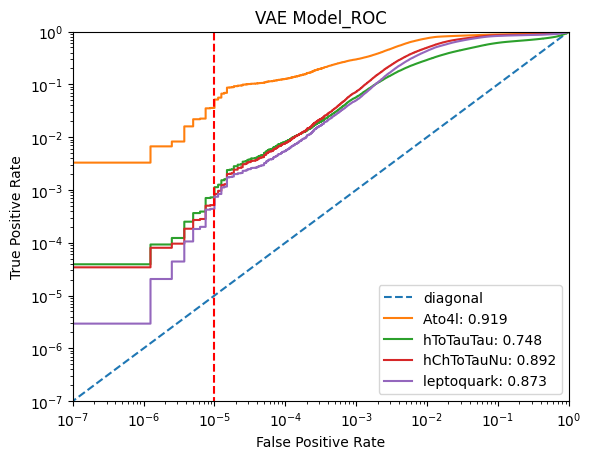


TPR at FPR = 1e-05 for each channel:
Ato4l: 3.568047%, Threshold = 38862.449219
hToTauTau: 0.072329%, Threshold = 38862.449219
hChToTauNu: 0.051560%, Threshold = 38862.449219
leptoquark: 0.043754%, Threshold = 38862.449219


In [29]:
# Suppose:
#  - model_path points to the .pth or .pt file where you saved your PyTorch VAE weights
#  - X_test is your background test set (NumPy array)
#  - signal_data is a list of multiple signals [signal1, signal2, ...] (each is a NumPy array)
#  - br_weights is a NumPy array matching X_test
#  - signal_weights is a list of NumPy arrays, each matching the shape of a signal
#  - signal_labels is the label list for each signal

model_path = "/content/drive/My Drive/SLACResearch_Ivan/weights.pth"

input_dim = X_test.shape[1]
evaluation = Model_Evaluator(
    model_path=model_path,
    background=X_test,
    br_weights=np.ones(len(X_test)),      # or real background weights
    signal=signal_data,
    signal_weights=[
        np.ones(len(signal_data[0])),
        np.ones(len(signal_data[1])),
        np.ones(len(signal_data[2])),
        np.ones(len(signal_data[3])),
    ],
    input_dim=input_dim,
    title="VAE Model",
    save=False,
    labels=signal_labels,
    device="cuda"  # or "cpu"
)

Losses = ["CKL"]  # or ["KL"] or both
for l_type in Losses:
    evaluation.calculate_loss(l_type)
    evaluation.ROC()
